# Описание проекта

Для нефтегазовой компании нужно определить, где целесообразнее всего пробурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Составим краткий план работы с проектом:

1. Загрузить и подготовить данные;
2. Обучить и проверить модель для каждого региона;
3. Выполнить подготовку для расчета прибыли;
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели;
5. Посчитать риски и прибыль для каждого региона.

# 1. Загрузка и подготовка данных

In [1]:
# Отключим предупреждения Anaconda
import warnings

warnings.simplefilter("ignore")

# Будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns

sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

# Увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 8, 5
from math import sqrt

import numpy as np
import pandas as pd
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [2]:
def load_df(name_of_df, separator=",", ind=None):
    """Функция загружает датафрэйм и выводит основные данные по нему.
    Аргументы:
    name_of_df - путь к датафрэйму;
    separator - разделитель;
    ind - столбцы для использования в качестве номеров строк"""

    # Считаем и выведем первые 5 строк таблицы
    df = pd.read_csv(name_of_df, sep=separator, index_col=ind)
    print("Выведем первые 5 строк таблицы:", end="\n\n")
    display(df.head())

    # Вывод основных описательных статистик, общей информации о таблице,
    # пропущенных значений, корреляции признаков, количества дубликатов в данных
    print(
        "\n\n\n\nОтобразим основные описательные статистики по признакам:", end="\n\n"
    )
    display(df.describe())
    print("\n\n\n\nПолучим общую информацию о таблице:", end="\n\n")
    display(df.info())
    print(f"\n\n\n\nПропущенные значения по признакам:", end="\n\n")
    display(pd.DataFrame(df.isnull().sum(), columns=["missing_values"]))
    print(f"\n\n\n\nКорреляция признаков:", end="\n\n")
    display(df.corr())
    sns.pairplot(df.drop(["id"], axis=1))
    return df

У нас имеется три файла формата csv (geo_data_0.csv, geo_data_1.csv, geo_data_2.csv). В каждом файле имеются три столбца (признака):

> id — уникальный идентификатор скважины;<br>
> f0, f1, f2 — три признака точек;<br>
> product — объём запасов в скважине (тыс. баррелей);<br>

Откроем файлы, и ознакомимся со структурой файлов, а также получим общую информацию.

Выведем первые 5 строк таблицы:



,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280
1,2acmU,1.335,-0.340,4.365,73.038
2,409Wp,1.023,0.152,1.420,85.266
3,iJLyR,-0.032,0.139,2.979,168.621
4,Xdl7t,1.988,0.155,4.752,154.037






Отобразим основные описательные статистики по признакам:



,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.500,0.250,2.503,92.500
std,0.872,0.504,3.248,44.289
min,-1.409,-0.848,-12.088,0.000
25%,-0.073,-0.201,0.288,56.498
50%,0.502,0.250,2.516,91.850
75%,1.074,0.701,4.715,128.564
max,2.362,1.344,16.004,185.364






Получим общую информацию о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None





Пропущенные значения по признакам:



,missing_values
id,0
f0,0
f1,0
f2,0
product,0






Корреляция признаков:



,f0,f1,f2,product
f0,1.000,-0.441,-0.003,0.144
f1,-0.441,1.000,0.002,-0.192
f2,-0.003,0.002,1.000,0.484
product,0.144,-0.192,0.484,1.000


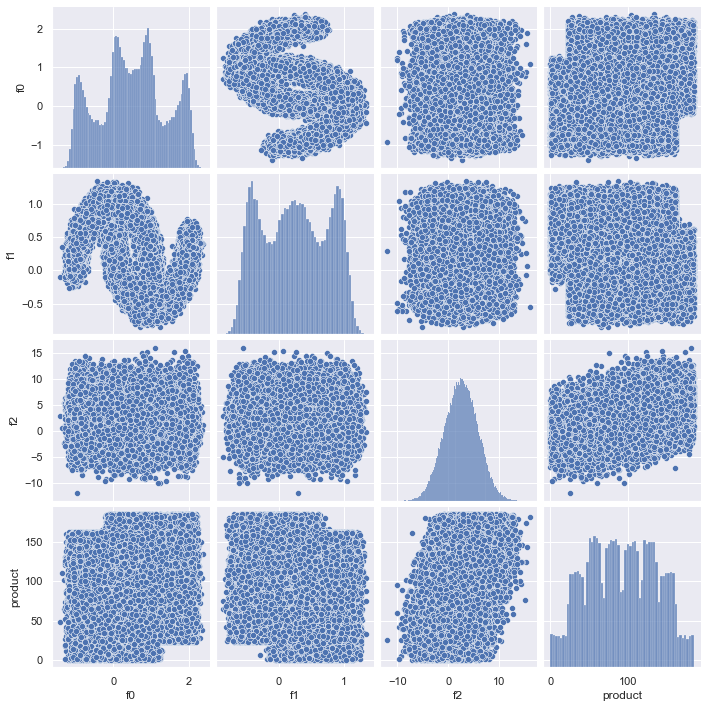

In [3]:
geo_df_0 = load_df("geo_data_0.csv")

Выведем первые 5 строк таблицы:



,id,f0,f1,f2,product
0,kBEdx,-15.001,-8.276,-0.006,3.179
1,62mP7,14.272,-3.475,0.999,26.953
2,vyE1P,6.263,-5.948,5.001,134.766
3,KcrkZ,-13.081,-11.506,4.999,137.945
4,AHL4O,12.702,-8.147,5.004,134.766






Отобразим основные описательные статистики по признакам:



,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,1.141,-4.797,2.495,68.825
std,8.966,5.120,1.704,45.944
min,-31.610,-26.359,-0.018,0.000
25%,-6.299,-8.268,1.000,26.953
50%,1.153,-4.813,2.011,57.086
75%,8.621,-1.333,4.000,107.813
max,29.422,18.734,5.020,137.945






Получим общую информацию о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None





Пропущенные значения по признакам:



,missing_values
id,0
f0,0
f1,0
f2,0
product,0






Корреляция признаков:



,f0,f1,f2,product
f0,1.000,0.182,-0.002,-0.030
f1,0.182,1.000,-0.003,-0.010
f2,-0.002,-0.003,1.000,0.999
product,-0.030,-0.010,0.999,1.000


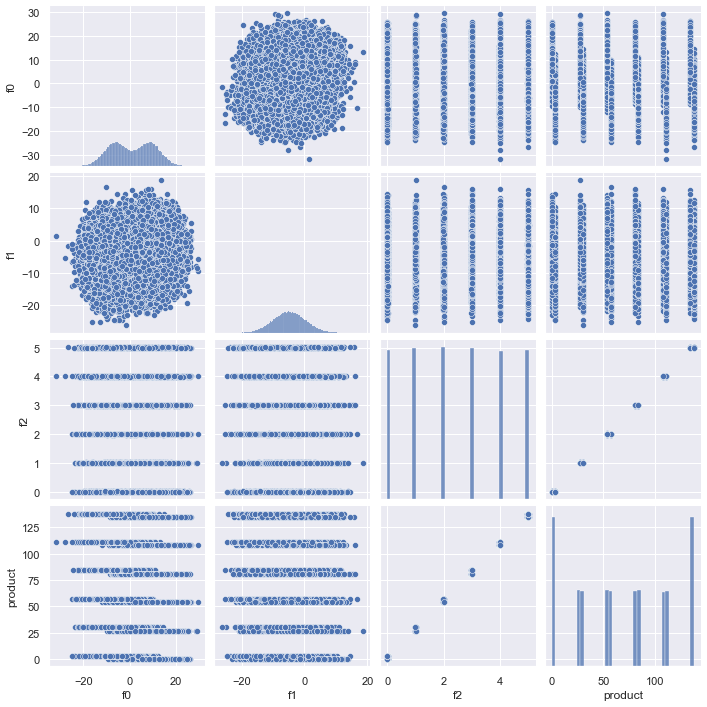

In [4]:
geo_df_1 = load_df("geo_data_1.csv")

Выведем первые 5 строк таблицы:



,id,f0,f1,f2,product
0,fwXo0,-1.147,0.963,-0.829,27.759
1,WJtFt,0.263,0.270,-2.530,56.070
2,ovLUW,0.195,0.289,-5.586,62.872
3,q6cA6,2.236,-0.554,0.930,114.573
4,WPMUX,-0.516,1.716,5.899,149.601






Отобразим основные описательные статистики по признакам:



,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.002,-0.002,2.495,95.000
std,1.732,1.730,3.473,44.750
min,-8.760,-7.084,-11.970,0.000
25%,-1.162,-1.175,0.130,59.450
50%,0.009,-0.009,2.484,94.926
75%,1.159,1.164,4.859,130.595
max,7.238,7.845,16.739,190.030






Получим общую информацию о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None





Пропущенные значения по признакам:



,missing_values
id,0
f0,0
f1,0
f2,0
product,0






Корреляция признаков:



,f0,f1,f2,product
f0,1.000,0.001,-0.000,-0.002
f1,0.001,1.000,0.001,-0.001
f2,-0.000,0.001,1.000,0.446
product,-0.002,-0.001,0.446,1.000


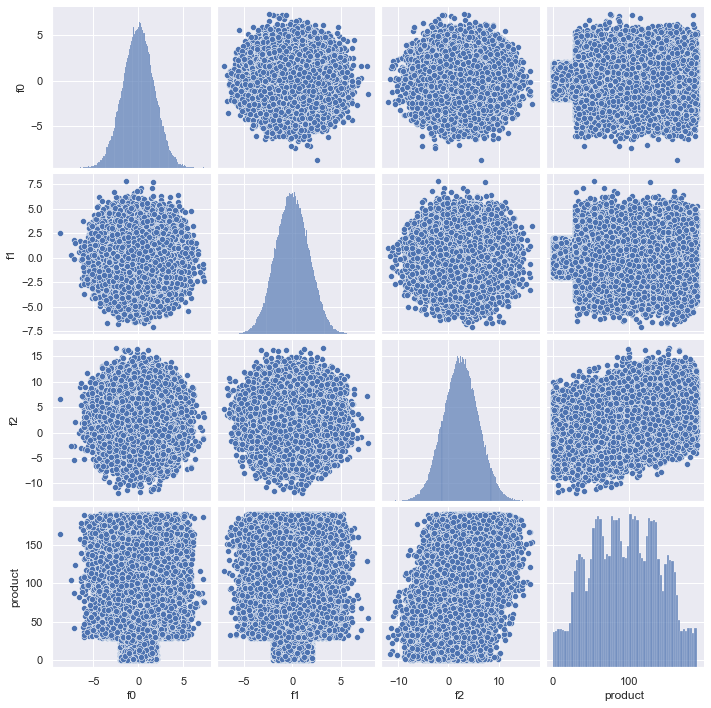

In [5]:
geo_df_2 = load_df("geo_data_2.csv")

Мы получили 3 датафрэйма, каждый из которых состоит из 4 признаков: id (тип object), f0 (тип float), f1  (тип float), f2  (тип float), product  (тип float). Также какждый датафрэйм имеет 100 000 строк (объектов), которые содержат информацию о конкретной скважине.

Прежде чем применить модель машинного обучения - линейную регрессию, подготовим данные. Для этого можем попробовать использовать несколько подходов: логарифмирование значений признаков, стандартизацию, нормализацию, а также преобразование с помощью алгоритма RobustScaler. В случе применения алгоритмов, основанных на деревьях решений, такие преобразования не принесут результатов, однако в случае с линейной регрессией, это может в значительной степени повысить метрики линейной регрессии.

Далее преобразования мы можем использовать с помощью конвеера - Pipeline. Однако посмотрим, преобразование (стандартизация, нормализация, RobustScaler()) отразится на визуализации данных.

In [6]:
numeric = ["f0", "f1", "f2", "product"]

In [7]:
geo_df_0_stand, geo_df_0_norm, geo_df_0_robust = (
    geo_df_0.copy(),
    geo_df_0.copy(),
    geo_df_0.copy(),
)

In [8]:
scaler = StandardScaler()
scaler.fit(geo_df_0_stand[numeric])

StandardScaler()

In [9]:
geo_df_0_stand[numeric] = scaler.transform(geo_df_0_stand[numeric])

In [10]:
geo_df_0_stand

,id,f0,f1,f2,product
0,txEyH,0.236,-1.483,-0.395,0.289
1,2acmU,0.957,-1.170,0.573,-0.439
2,409Wp,0.599,-0.195,-0.333,-0.163
3,iJLyR,-0.611,-0.220,0.147,1.719
4,Xdl7t,1.707,-0.188,0.692,1.389
...,...,...,...,...,...
99995,DLsed,0.541,0.239,1.100,0.412
99996,QKivN,1.023,-1.254,-0.378,0.674
99997,3rnvd,0.607,-0.459,-1.186,-0.635
99998,7kl59,0.571,-1.544,-0.283,-0.417


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(geo_df_0_norm[numeric])

MinMaxScaler()

In [12]:
geo_df_0_norm[numeric] = scaler.transform(geo_df_0_norm[numeric])

In [13]:
geo_df_0_norm

,id,f0,f1,f2,product
0,txEyH,0.561,0.160,0.474,0.568
1,2acmU,0.727,0.232,0.586,0.394
2,409Wp,0.645,0.456,0.481,0.460
3,iJLyR,0.365,0.450,0.536,0.910
4,Xdl7t,0.901,0.458,0.599,0.831
...,...,...,...,...,...
99995,DLsed,0.631,0.556,0.647,0.597
99996,QKivN,0.743,0.212,0.476,0.660
99997,3rnvd,0.647,0.396,0.382,0.347
99998,7kl59,0.638,0.146,0.487,0.399


In [14]:
scaler = RobustScaler()
scaler.fit(geo_df_0_robust[numeric])

RobustScaler()

In [15]:
geo_df_0_robust[numeric] = scaler.transform(geo_df_0_robust[numeric])

Теперь визуализируем данные и сравним полученные результаты.

In [16]:
#%config InlineBackend.figure_format = 'svg'

rcParams["figure.figsize"] = 8, 5

Text(0.5, 1.0, 'Распределение количественных признаков до преобразований')

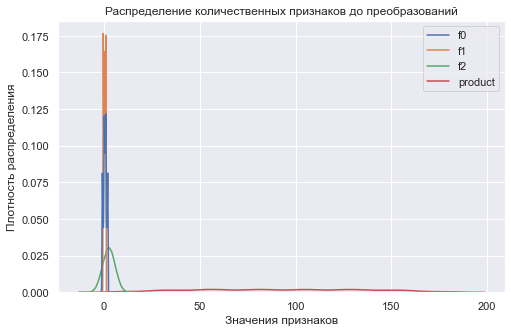

In [17]:
f, ax = plt.subplots()
sns.kdeplot(data=geo_df_0[numeric])
ax.set(xlabel="Значения признаков", ylabel="Плотность распределения")
ax.set_title("Распределение количественных признаков до преобразований")

Text(0.5, 1.0, 'Распределение количественных признаков после стандартизации')

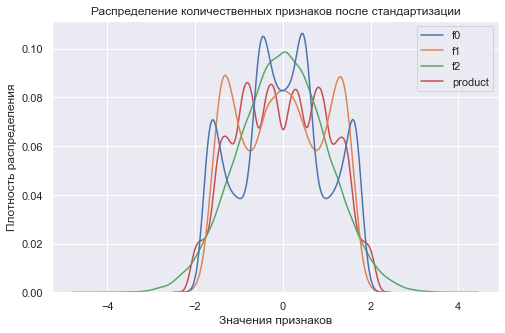

In [18]:
f, ax = plt.subplots()
sns.kdeplot(data=geo_df_0_stand[numeric])
ax.set(xlabel="Значения признаков", ylabel="Плотность распределения")
ax.set_title("Распределение количественных признаков после стандартизации")

Text(0.5, 1.0, 'Распределение количественных признаков после нормализации')

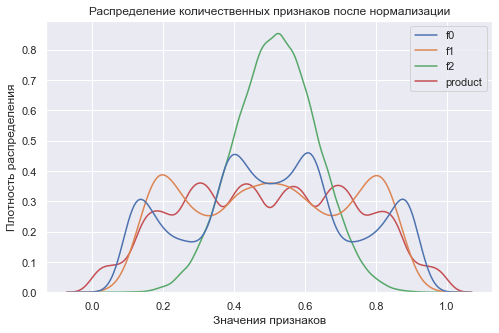

In [19]:
f, ax = plt.subplots()
sns.kdeplot(data=geo_df_0_norm[numeric])
ax.set(xlabel="Значения признаков", ylabel="Плотность распределения")
ax.set_title("Распределение количественных признаков после нормализации")

Text(0.5, 1.0, 'Распределение количественных признаков после преобразования RobustScaler')

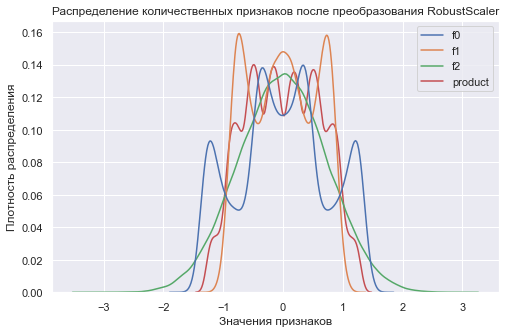

In [20]:
f, ax = plt.subplots()
sns.kdeplot(data=geo_df_0_robust[numeric])
ax.set(xlabel="Значения признаков", ylabel="Плотность распределения")
ax.set_title("Распределение количественных признаков после преобразования RobustScaler")

Ожидаемо, проанализировать распределение признаков на одном графике до их преобразования не представляется возможным, т.к. они имеют разный масштаб. В остальных случаях мы получили визуальное представление признаков. Пока сложно сказать, какое преобразование будет давать наилучший эффект при обучении модели, это будет установлено эмпирическим путём.

## Вывод

Мы изучили структуру каждого датафрэйма: они содержат по 4 столбца (признака), а также по 100 000 строк (объектов). 

Для модели линейной регрессии важно, чтобы признаки имели одинаковый масштаб, поэтому мы воспользовались такими методами как:
* стандартизация - приведение всех количественных переменных к одному масштабу: преобразует данные так, что их распределение будет иметь среднее значение 0 и стандартное отклонение 1;
* нормализация - приводит признаки к одному масштабу, и их значения будут варьироваться в диапазоне от 0 до 1;
* RobustScaler полезен, если в данных содержатся выбросы, их влияние можно нивелировать. RobustScaler преобразует вектор признаков путем вычитания медианы, а затем деления на диапазон между четвертями (значение 75% - значение 25%). Однако, стоит понимать, что RobustScaler не масштабирует данные в заранее определенный интервал, как MinMaxScaler.

Также мы визуализировали данные после преобразований, а наилучший вариант преобразования будет подобран с помощью GridSearchCV.

# 2. Обучение и проверка модели

Для каждого датасэта выполним разбиение на тренировочные (train) и тестовые (test) выборки в соотношении 75:25 c помощью train_test_split.

In [21]:
X_0 = geo_df_0.drop(["id", "product"], axis=1)

In [22]:
y_0 = geo_df_0["product"]

In [23]:
X_1 = geo_df_1.drop(["id", "product"], axis=1)

In [24]:
y_1 = geo_df_1["product"]

In [25]:
X_2 = geo_df_2.drop(["id", "product"], axis=1)

In [26]:
y_2 = geo_df_2["product"]

In [27]:
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(
    X_0, y_0, test_size=0.25, random_state=12345, shuffle=True
)

In [28]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(
    X_1, y_1, test_size=0.25, random_state=12345, shuffle=True
)

In [29]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(
    X_2, y_2, test_size=0.25, random_state=12345, shuffle=True
)

Создадим сетку параметров. Наилучшие варианты преобразований данных будут подобраны с помощью GridSearchCVGridSearchCV.

In [30]:
n_features = [1, 2, 3]

param_grid = [
    {
        "preprocessor__scaler": [
            StandardScaler(),
            RobustScaler(),
            MinMaxScaler(feature_range=(0, 1)),
        ]
    },
    {
        "preprocessor__scaler": [
            StandardScaler(),
            RobustScaler(),
            MinMaxScaler(feature_range=(0, 1)),
        ],
        "preprocessor__feature_selection": [PCA()],
        "preprocessor__feature_selection__n_components": n_features,
    },
    {
        "preprocessor__scaler": [
            StandardScaler(),
            RobustScaler(),
            MinMaxScaler(feature_range=(0, 1)),
        ],
        "preprocessor__feature_selection": [SelectKBest(chi2)],
        "preprocessor__feature_selection__k": n_features,
    },
]

In [31]:
# создадим "контейнер", куда запишем значения основных метрик для модели

comparison_of_models = pd.DataFrame()

In [32]:
def model_plot(y_test, y_pred):
    """Функция строит графики для оценки модели.
    На первом графике показано качество предсказания модели.
    На втором - сравнение распределений целевого признака
    для тестовых данных и для предсказанных данных.
    Аргументы:
    y_test - тестовые данные целевого признака;
    y_pred - предсказанные данные целевого признака"""

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes[0].scatter(y_pred, y_test, alpha=0.3, label="Данные")
    axes[0].set_xlabel("Истинные значения")
    axes[0].set_ylabel("Предсказанные значения")
    x_vals = np.array(axes[0].get_xlim())
    y_vals = x_vals
    axes[0].plot(x_vals, y_vals, ls="--", c="red", label="Идеальное предсказание")
    axes[0].legend(loc="upper left")
    axes[0].set_title("Качество предсказания модели")

    axes[1].hist(y_test, bins=50, alpha=1, label="Истинные значения")
    axes[1].set_xlabel("product")
    axes[1].hist(
        y_pred, bins=50, alpha=0.7, label="Предсказанные значения", color="red"
    )
    axes[1].legend(loc="upper right")
    axes[1].set_title("Распределение целевого признака")

In [33]:
def model_score_test(X_train, X_test, y_train, y_test, name, param_grid=param_grid):
    """Функция строит предсказания с помощью линейной регрессии, подбирая наилучшие
    варианты преобразований с помощью Pipeline и GridSearchCV.
    Результатом работы функции являются график оценки модели,
    вывод наилучших вариантов преобразования модели,
    таблица со значениями метрик MAE, MSE, RMSE, R2.
    Аргументы:
    X_train - тренировочные данные для обучения модели;
    X_test - тестовые данные для предсказания целевого признака;
    y_train - значения целевого признака для обучения модели;
    y_test - значение целевого признака для вычисления метрик;
    name - наименование объекта;
    param_grid - сетка параметров."""

    global comparison_of_models
    preprocessor = Pipeline(
        steps=[("scaler", "passthrough"), ("feature_selection", "passthrough")]
    )
    classifier = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", LinearRegression(n_jobs=-1)),
        ]
    )

    grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    y_pred = grid_search.predict(X_test)

    model_plot(y_test, y_pred)

    test_mean = y_test.mean()
    test_pred_mean = y_pred.mean()
    pred_MAE = mean_absolute_error(y_test, y_pred)
    pred_MSE = mean_squared_error(y_test, y_pred)
    pred_RMSE = sqrt(pred_MSE)
    pred_R2 = r2_score(y_test, y_pred)
    temp_data = pd.DataFrame(
        {
            "name": [name],
            "test_mean": [test_mean],
            "test_pred_mean": [test_pred_mean],
            "pred_MAE": [pred_MAE],
            "pred_MSE": [pred_MSE],
            "pred_RMSE": [pred_RMSE],
            "pred_R2": [pred_R2],
        }
    )
    comparison_of_models = comparison_of_models.append(temp_data)
    comparison_of_models = comparison_of_models.reset_index(drop=True)
    print(
        f"Для улучшения модели использовались следующие параметры: {best_params}",
        end="\n\n",
    )
    display(comparison_of_models)
    # y_pred = pd.DataFrame(data=y_pred, columns=["oil_predictions"])
    return pd.Series(y_pred, index=y_test.index)

Для улучшения модели использовались следующие параметры: {'preprocessor__scaler': MinMaxScaler()}



,name,test_mean,test_pred_mean,pred_MAE,pred_MSE,pred_RMSE,pred_R2
0,region_0,92.079,92.593,30.920,1412.213,37.579,0.280


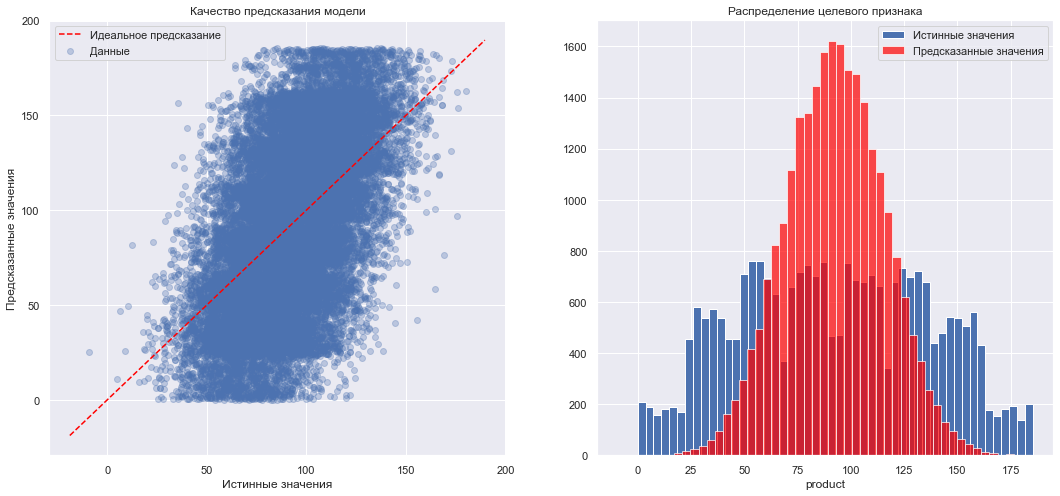

In [34]:
pred_region_0 = model_score_test(X_0_train, X_0_test, y_0_train, y_0_test, "region_0")

Для улучшения модели использовались следующие параметры: {'preprocessor__scaler': StandardScaler()}



,name,test_mean,test_pred_mean,pred_MAE,pred_MSE,pred_RMSE,pred_R2
0,region_0,92.079,92.593,30.920,1412.213,37.579,0.280
1,region_1,68.723,68.729,0.719,0.798,0.893,1.000


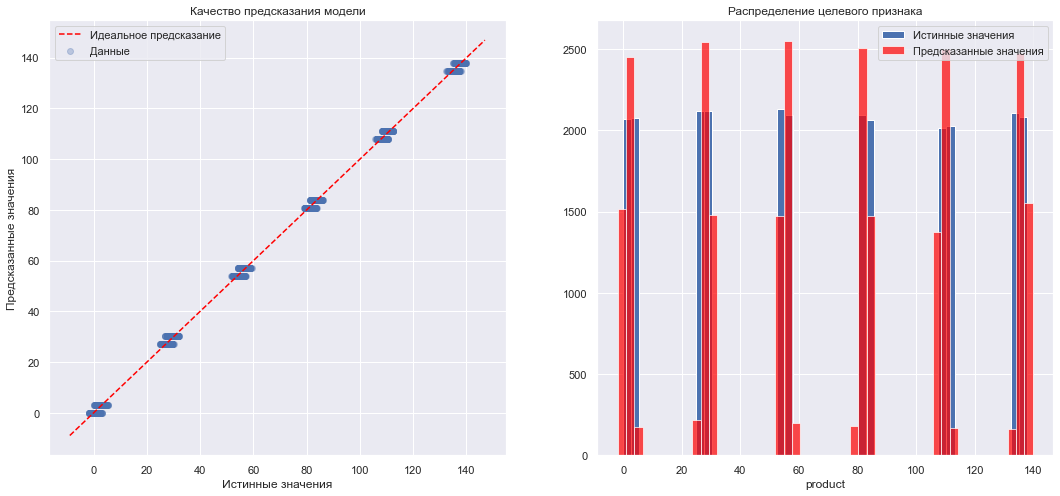

In [35]:
pred_region_1 = model_score_test(X_1_train, X_1_test, y_1_train, y_1_test, "region_1")

Для улучшения модели использовались следующие параметры: {'preprocessor__feature_selection': PCA(n_components=2), 'preprocessor__feature_selection__n_components': 2, 'preprocessor__scaler': MinMaxScaler()}



,name,test_mean,test_pred_mean,pred_MAE,pred_MSE,pred_RMSE,pred_R2
0,region_0,92.079,92.593,30.920,1412.213,37.579,0.280
1,region_1,68.723,68.729,0.719,0.798,0.893,1.000
2,region_2,94.884,94.965,32.793,1602.387,40.030,0.205


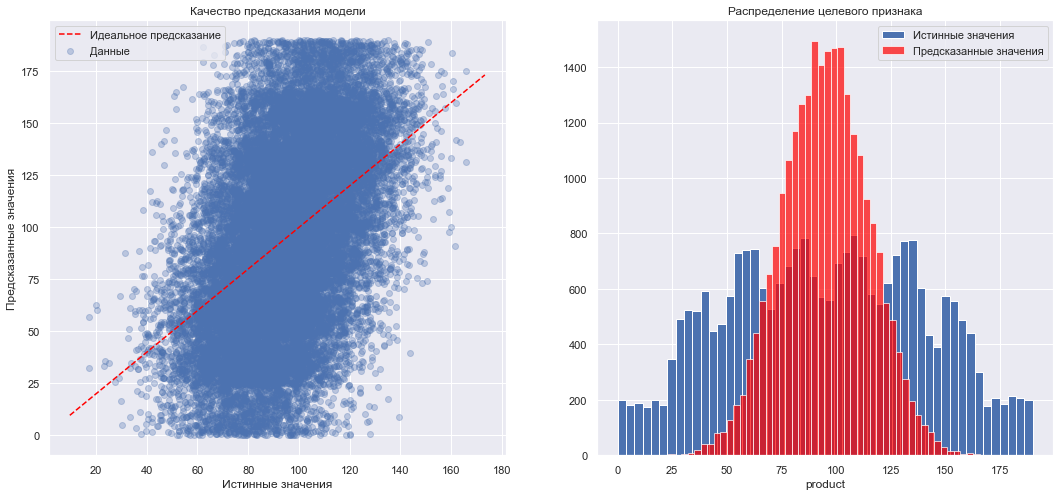

In [36]:
pred_region_2 = model_score_test(X_2_train, X_2_test, y_2_train, y_2_test, "region_2")

Качество предсказаний для линейной регресси оцениваются с помощью метрик: MAE, MSE, RMSE, R2.

* MAE - средняя абсолютная ошибка (Mean Absolute Error (MAE)). Метрика измеряет среднюю сумму абсолютной разницы между фактическим значением и прогнозируемым значением. Расчет производится по формуле:

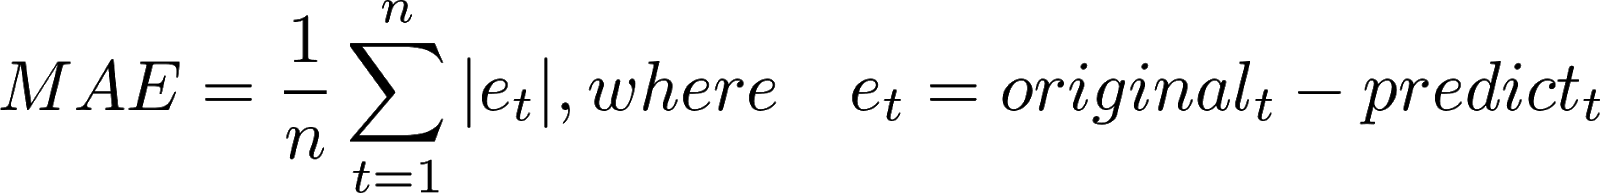

* MSE - среднеквадратическая ошибка (Mean squared error, MSE). Метрика измеряет среднюю сумму квадратной разности между фактическим значением и прогнозируемым значением для всех точек данных. Выполняется возведение во вторую степень, поэтому отрицательные значения не компенсируют положительными. А также в силу свойств этой метрики, усиливается влияние ошибок, по квадратуре от исходного значения. Это значит, что если в в исходных измерениях мы ошиблись на 1, то метрика покажет 1, 2-4, 3-9 и так далее. Чем меньше MSE, тем точнее наше предсказание. Оптимум достигается в точке 0, то есть мы идеально предсказываем. Расчет метрики производится по формуле:

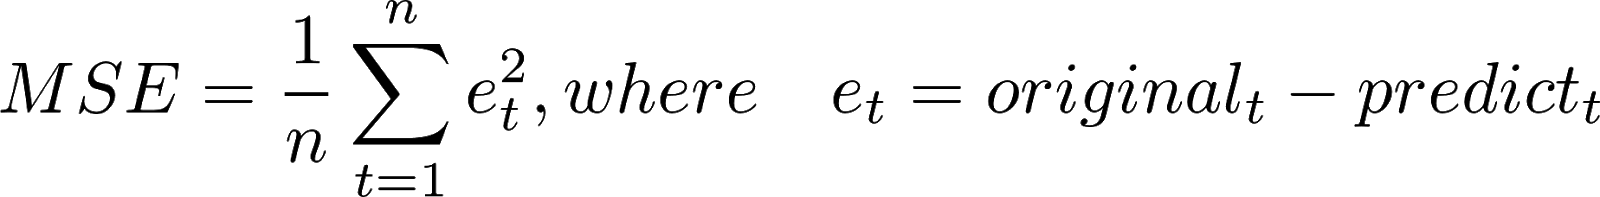

RMSE - корень из среднеквадратической ошибки (Root Mean Squared Error (RMSE)). Метрику RMSE легко интерпретировать, поскольку она имеет те же единицы, что и исходные значения (в отличие от MSE). Формула расчета:

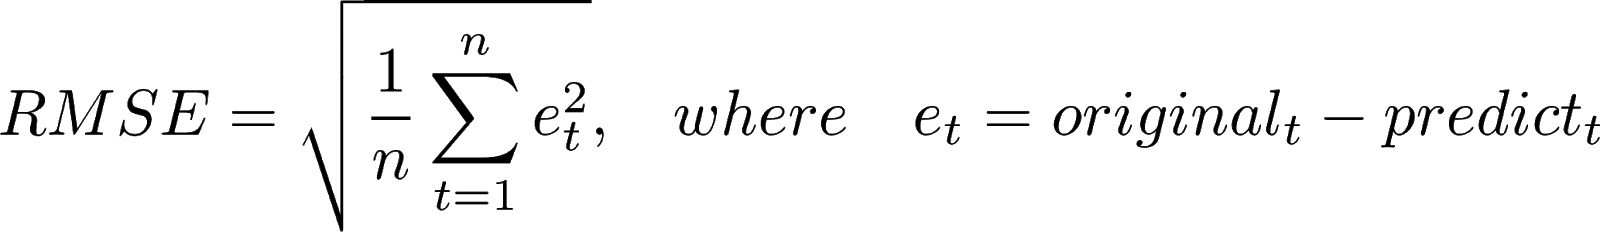

R2 - коэффициент детерминации. Эта метрика показывает, насколько условная дисперсия модели отличается от дисперсии реальных значений Y. Если этот коэффициент близок к 1, то условная дисперсия модели достаточно мала и весьма вероятно, что модель неплохо описывает данные. Если же коэффициент R-квадрат сильно меньше, например, меньше 0.5, то, с большой долей уверенности модель не отражает реальное положение вещей. R2 рассчитывается по формуле:

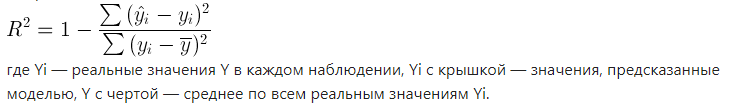

Мы получили предсказания, а также значения метрик MAE, MSE, RMSE, R2 для предсказаний по каждому региону. Интерпретируем полученные результаты.

Среднее значение сырья на тестовых данных для нулевого региона равно 92,08 тыс. баррелей. Предсказанное среднее значение модели немного выше - 92,59 тыс. баррелей. Средняя абсолютная ошибка (MAE) - 30,92. Метрику MSE интерпретировать довольно сложно ввиду размерности, поэтому перейдем к метрике RMSE. Значение RMSE для нулевого региона - 37,58. То есть можно предположить, что в среднем модель будет ошибаться на 37,58 - это достаточно большой разброс. Также мы видим низкое значение метрики R2. То, что она выше нуля показывает, что модель работает лучше, чем случайная, однако значение R2 менее 0,5 говорит о невысокой точности предсказаний.

По первому региону среднее значение сырья на тестовых данных - 68,72 тыс. баррелей. Предсказанное среднее значение модели для сырья - 68,73 тыс. баррелей. Значение средней абсолютной ошибки (MAE) - 0,72. RMSE равно 0,89, что является хорошим результатом. Такой результат был получен за счет того, что в случае с первым регионом признак f2 сильно коррелирует (коэффициент корреляции равен 0,99) с целевой переменной product. Модель в среднем ошибается на 0,89 - это хороший результат. Еще одним показателем высокой точности предсказания для первого региона является показатель R2, который в случае идеальных предсказаний равен 1.

Для второго региона среднее значения сырья у тестовых данных равно 94,88 тыс. баррелей. Среднее предсказанное значение сырья - 94,96 тыс. баррелей. Значение средней абсолютной ошибки (MAE) - 32,79. RMSE равно 40,03 - это большой разброс для ошибки при том, что среднее предсказанное значение равно 94,96

## Вывод

Мы спрогнозировали объем запасов нефти для трёх регионов, использовав для обучения модель линейной регрессии. Результаты для нулевого и второго региона получились довольно похожими: низкое значения метрики R2 ввиду отсутствия высокой степени корреляции целевого признака с другими признаками. 

Для первого региона мы получили качественные предсказания: значение метрики R2 практически равно 1. Среднее значение предсказанных результатов получилось 94,96, а RMSE - всего 0,89.

# 3. Подготовка к расчёту прибыли

Подготовим ключевые значения для расчёта прибыли. Вспомним, что согласно исходным данным:

* Бюджет на разработку скважин в регионе — 10 млрд рублей;
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [37]:
budget = 10000000000
profit_per_1000_bar = 450000
number_of_oil_wells = 200

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. То есть нам нужно добыть такое количество топлива, чтобы суммарная прибыль от её продажи превысила 10 млрд рублей.

In [38]:
need_to_produce = budget / profit_per_1000_bar
need_to_produce

22222.222222222223

То есть добычу нефти можно назвать рентабельной в том случае, если будет добыть свыше 22 223 тыс. баррелей с помощью 200 скважин. Посчитаем, какое количество нефти в среднем должно добываться из каждой скважины.

In [39]:
need_to_produce_per_oil_well = need_to_produce / number_of_oil_wells
need_to_produce_per_oil_well

111.11111111111111

В среднем с каждой скважины необходимо добывать 111,11 тыс. баррелей нефти, чтобы это было рентабельным. Сравним полученный объём сырья со средним запасом в каждом регионе, представив данные в табличном виде, где:

* region - номер региона;
* need_to_produce - общее количество нефти, которое нужно добыть, тыс. баррелей;
* need_to_produce_per_oil_well - пороговое значение: сколько в среднем нужно добывать с каждой скважины, чтобы не понести убытки, но и не получить прибыль, тыс. баррелей;
* mean_res_per_oil_well - среднее количество нефти каждой скважины, тыс. баррелей;
* total_res - общее количество запасов нефти по региону, тыс. баррелей;
* ammount_of_right_wells - число скважин запасы которых больше порогового значения;
* roportion_of_right_wells - доля скважин запасы которых больше порогового значения.

In [40]:
region_comparing = pd.DataFrame(
    {
        "region": ["region_0", "region_1", "region_2"],
        "need_to_produce": [
            round(need_to_produce, 3),
            round(need_to_produce, 3),
            round(need_to_produce, 3),
        ],
        "need_to_produce_per_oil_well": [
            round(need_to_produce_per_oil_well, 3),
            round(need_to_produce_per_oil_well, 3),
            round(need_to_produce_per_oil_well, 3),
        ],
        "mean_res_per_oil_well": [y_0.mean(), y_1.mean(), y_2.mean()],
        "total_res": [y_0.sum(), y_1.sum(), y_2.sum()],
        "ammount_of_right_wells": [
            len(y_0.loc[y_0 > 111.12]),
            len(y_1.loc[y_1 > 111.12]),
            len(y_2.loc[y_2 > 111.12]),
        ],
        "roportion_of_right_wells": [
            len(y_0.loc[y_0 > 111.12]) / len(y_0),
            len(y_1.loc[y_1 > 111.12]) / len(y_1),
            len(y_2.loc[y_2 > 111.12]) / len(y_2),
        ],
    }
)

In [41]:
region_comparing

,region,need_to_produce,need_to_produce_per_oil_well,mean_res_per_oil_well,total_res,ammount_of_right_wells,roportion_of_right_wells
0,region_0,22222.222,111.111,92.500,9250000.000,36577,0.366
1,region_1,22222.222,111.111,68.825,6882500.000,16537,0.165
2,region_2,22222.222,111.111,95.000,9500000.000,38171,0.382


## Вывод

Очевидно, что запасов нефти в каждом из регионов хватает, чтобы обеспечить чистую прибыль после реализации добытой нефти, однако, нам нужно выбрать лишь 200 лучших скважин. 

В среднем каждая скважина в нулевом регионе содержит 92,5 тыс. баррелей нефти, для получения чистой прибыли необходимо в среднем добывать свыше 111,11 тыс. баррелей. Это достижимая задача, т.к. в первом регионе имеется 36 577 шт. (36,58% от всего количества скважин по нулевому региону), в которых запасы нефти выше порогового значения в 111,11 тыс. баррелей.

В первом регионе среднее запасов нефтяной скважины значение значительно меньше - 68,83 тыс. баррелей, а, следовательно, и количество/доля скважин, запасы которых выше порогового значения будет меньше - 16 537 шт. (16,54% от всего количество скважин по первому региону).

Второй регион отчасти похож на первый: среднее количество нефти, которая приходится на каждую скважину, 95 тыс. баррелей. Количество таких скважин по второму региону составляет 38 171 шт. (38,17% от всего количества скважин по втор региону. 

# 4. Расчет рисков и прибыли для каждого региона

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [42]:
list_of_predictions = [
    pred_region_0.sort_values(ascending=False)[:200],
    pred_region_1.sort_values(ascending=False)[:200],
    pred_region_2.sort_values(ascending=False)[:200],
]

In [43]:
def profit_per_reg(df, list_of_predictions, column):
    """Функция добавляет в датафрэйм признак с суммой
    количества нефти (тыс. баррелей) для 200 лучших
    точек в каждом регионе.
    
    Аргументы:
    df - датафрэйм, куда будет добавлен столбец с суммарным количеством нефти;
    list_of_predictions - список с предсказанными значениями запасов нефти по регионам;
    column - наименование нового признака."""
    
    df.loc[0, column] = round(list_of_predictions[0].sum(), 3)
    df.loc[1, column] = round(list_of_predictions[1].sum(), 3)
    df.loc[2, column] = round(list_of_predictions[2].sum(), 3)
    df["predicted_profit"] = df.loc[:, column].apply(
        lambda x: x * profit_per_1000_bar - budget
    )
    return df

In [44]:
region_comparing = profit_per_reg(
    region_comparing, list_of_predictions, "top_200_sum_oil_preds"
)

In [45]:
region_comparing

,region,need_to_produce,need_to_produce_per_oil_well,mean_res_per_oil_well,total_res,ammount_of_right_wells,roportion_of_right_wells,top_200_sum_oil_preds,predicted_profit
0,region_0,22222.222,111.111,92.500,9250000.000,36577,0.366,31102.331,3996048950.000
1,region_1,22222.222,111.111,68.825,6882500.000,16537,0.165,27746.027,2485712150.000
2,region_2,22222.222,111.111,95.000,9500000.000,38171,0.382,29603.849,3321732050.000


Мы получили, что валовая прибыль при выборе 200 наиболее выгодных скважин для каждого из регионов составит соответственно:
* 3,996 млрд. рублей;
* 2,486 млрд. рублей;
* 3,322 млрд. рублей.

Для того, чтобы найти распределение прибыли применим технику Bootstrap. 

Bootstrap — метод исследования распределения статистик вероятностных распределений, основанный на многократной генерации выборок методом Монте-Карло на базе имеющейся выборки. Позволяет просто и быстро оценивать самые разные статистики (доверительные интервалы, дисперсию, корреляцию и так далее) для сложных моделей.

Суть метода состоит в том, чтобы по имеющейся выборке построить эмпирическое распределение. Используя это распределение как теоретическое распределение вероятностей, можно сгенерировать практически неограниченное количество псевдовыборок произвольного размера, например, того же, как у исходной. На множестве псевдовыборок можно оценить не только анализируемые статистические характеристики, но и изучить их вероятностные распределения. Таким образом, например, оказывается возможным оценить дисперсию или квантили любой статистики независимо от её сложности. Данный метод является методом непараметрической статистики.

In [46]:
def profit(target, pred, count):
    """Функция производит расчет прибыли по целевой переменной
    для указанного количества лучших предсказанных значений.
    
    Аргументы:
    target - реальные занчения целевого признака;
    pred - предсказанные значения целевого признака;
    count - число лучших значений предсказанного признака, которые нужно отобрать."""
    
    sorted_pred = pred.sort_values(ascending=False)
    selected = target.loc[sorted_pred.index][:count]
    summary_oil = selected.sum()
    revenue = summary_oil * profit_per_1000_bar
    profit = revenue - budget
    return profit

In [47]:
def profit_bootstrap(target, pred, region, iterations=1000, wells=200, total_wells=500):
    """Функция применяет технику Bootstrap, чтобы найти распределение прибыли
    по регионам.
    
    Аргументы:
    target - реальные занчения целевого признака;
    pred - предсказанные значения целевого признака;
    region - порядковый номер региона;
    iterations - число итераций;
    wells - число лучших скважин, которые будут разрабатываться;
    total_wells - число скважин, которые нужно проверить."""
    
    
    state = np.random.RandomState(12345)
    profits = []
    count_loss = 0
    for iteration in range(iterations):
        target_subsample = target.sample(
            n=total_wells, replace=True, random_state=state
        )
        pred_subsample = pred[target_subsample.index]
        prft = profit(target_subsample, pred_subsample, wells)
        profits.append(prft)
        if prft < 0:
            count_loss += 1
    profits = pd.Series(profits)
    conf_interval = st.t.interval(0.95, iterations - 1, profits.mean(), profits.sem())
    prob_loss = count_loss / 1000

    region_comparing.loc[region, "mean_profit_bootstrap"] = profits.mean()
    region_comparing.loc[region, "prob_loss"] = prob_loss
    
    print(f"Средняя прибыль по региону: {profits.mean()}")
    print(f"95% доверительный интервал: {conf_interval}")
    display(region_comparing)

    return profits

In [48]:
bootstrap_reg_0 = profit_bootstrap(y_0_test, pred_region_0, 0)

Средняя прибыль по региону: 425938526.91059244
95% доверительный интервал: (408732207.06869864, 443144846.7524862)


,region,need_to_produce,need_to_produce_per_oil_well,mean_res_per_oil_well,total_res,ammount_of_right_wells,roportion_of_right_wells,top_200_sum_oil_preds,predicted_profit,mean_profit_bootstrap,prob_loss
0,region_0,22222.222,111.111,92.500,9250000.000,36577,0.366,31102.331,3996048950.000,425938526.911,0.060
1,region_1,22222.222,111.111,68.825,6882500.000,16537,0.165,27746.027,2485712150.000,NaN,NaN
2,region_2,22222.222,111.111,95.000,9500000.000,38171,0.382,29603.849,3321732050.000,NaN,NaN


In [49]:
bootstrap_reg_1 = profit_bootstrap(y_1_test, pred_region_1, 1)

Средняя прибыль по региону: 515222773.4432899
95% доверительный интервал: (501621476.17632174, 528824070.710258)


,region,need_to_produce,need_to_produce_per_oil_well,mean_res_per_oil_well,total_res,ammount_of_right_wells,roportion_of_right_wells,top_200_sum_oil_preds,predicted_profit,mean_profit_bootstrap,prob_loss
0,region_0,22222.222,111.111,92.500,9250000.000,36577,0.366,31102.331,3996048950.000,425938526.911,0.060
1,region_1,22222.222,111.111,68.825,6882500.000,16537,0.165,27746.027,2485712150.000,515222773.443,0.010
2,region_2,22222.222,111.111,95.000,9500000.000,38171,0.382,29603.849,3321732050.000,NaN,NaN


In [50]:
bootstrap_reg_2 = profit_bootstrap(y_2_test, pred_region_2, 2)

Средняя прибыль по региону: 434822312.05915225
95% доверительный интервал: (417275951.6938572, 452368672.4244473)


,region,need_to_produce,need_to_produce_per_oil_well,mean_res_per_oil_well,total_res,ammount_of_right_wells,roportion_of_right_wells,top_200_sum_oil_preds,predicted_profit,mean_profit_bootstrap,prob_loss
0,region_0,22222.222,111.111,92.500,9250000.000,36577,0.366,31102.331,3996048950.000,425938526.911,0.060
1,region_1,22222.222,111.111,68.825,6882500.000,16537,0.165,27746.027,2485712150.000,515222773.443,0.010
2,region_2,22222.222,111.111,95.000,9500000.000,38171,0.382,29603.849,3321732050.000,434822312.059,0.063


Найдём 95-% доверительный интервал с помощью квантилей.

In [51]:
def conf_interval(lst):
    """Функция строит 95% доверительный интервал.
    Аргументы:
    lst - список с бустрапированными прибылями по регионам"""
    
    for region in enumerate(lst):
        region_comparing.loc[region[0], 'lower'] = lst[region[0]].quantile(0.025)
        region_comparing.loc[region[0], 'upper'] = lst[region[0]].quantile(0.975)
    return region_comparing

In [52]:
conf_interval([bootstrap_reg_0, bootstrap_reg_1, bootstrap_reg_2])

,region,need_to_produce,need_to_produce_per_oil_well,mean_res_per_oil_well,total_res,ammount_of_right_wells,roportion_of_right_wells,top_200_sum_oil_preds,predicted_profit,mean_profit_bootstrap,prob_loss,lower,upper
0,region_0,22222.222,111.111,92.500,9250000.000,36577,0.366,31102.331,3996048950.000,425938526.911,0.060,-102090094.838,947976353.358
1,region_1,22222.222,111.111,68.825,6882500.000,16537,0.165,27746.027,2485712150.000,515222773.443,0.010,68873225.371,931547591.257
2,region_2,22222.222,111.111,95.000,9500000.000,38171,0.382,29603.849,3321732050.000,434822312.059,0.063,-132046947.714,969706954.180


## Вывод

Мы посчитали риски и прибыль для каждого региона с помощью техники bootstrap. По условиям задачи, нам нужно выбрать регион, где вероятность убытков составляет менее 2,5%. Под это условие подходит только регион №1. Кроме того, в первом регионе с помощью бустрапа мы обнаружили самую высокую среднюю прибыль. Таким образом, для разработки скважин целесообразнее выбрать регион №1.